In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

from multiprocessing import Pool
import random
import numpy as np
import matplotlib.pyplot as mpl
#myColours=[]
#for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 10 ) ):
#    myColours.append( colour )
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 20E6, timeSec )

        necr, true, rPlusS = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

def NECRatTimeZr89( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = Zr89ActivityAtTime( 20E6, timeSec )

        necr, true, rPlusS = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We chose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source isotopes. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling.

In [3]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, isotope, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):
    
    tracerName = "Linear" + isotope
    isotopeMethod = NECRatTimeF18
    if isotope == "Zr89":
        isotopeMethod = NECRatTimeZr89
    
    # Fix random seed for reproducibility, don't if you want variation
    # Has to be set in this method, not before, because this is where we enter the worker processes
    random.seed( detectorLength )
    
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, tracerName, 1000000, 435.0, 585.0, CoincidenceWindow=coincidenceWindow )
    crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 1000000, 435.0, 585.0, CoincidenceWindow=coincidenceWindow )
    crystalActivity = sqp.Lu176decaysInMass( sqp.DetectorMassLength( detectorLength ) )

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = isotopeMethod( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, simulationWindow, coincidenceWindow )

    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, isotope, simulationWindow=1E-3, coincidenceWindow=4.7E-9, processes=10 ):
    
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, isotope, simulationWindow, coincidenceWindow ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )
    
    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
isotopes = [ "F18", "Zr89" ]
for isotope in isotopes:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( 700, isotope )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation
Re-using previous simulation
Re-using previous simulation
Re-using previous simulationRe-using previous simulation






64789.0 events loaded (1000000 simulated) with average 1.0184290543147756 hits/event
Re-using previous simulation
153183.0 events loaded (1000000 simulated) with average 1.0487390898467845 hits/event
Re-using previous simulation
227364.0 events loaded (1000000 simulated) with average 1.0797311799581288 hits/event
Re-using previous simulation
106276.0 events loaded (1000000 simulated) with average 1.0058903233091196 hits/event
106817.0 events loaded (1000000 simulated) with average 1.0066468820506098 hits/event
361780.0 events loaded (1000000 simulated) with average 1.153142793963182 hits/event
332115.0 events loaded (1000000 simulated) with average 1.1387501317314785 hits/event
Re-using previous simul

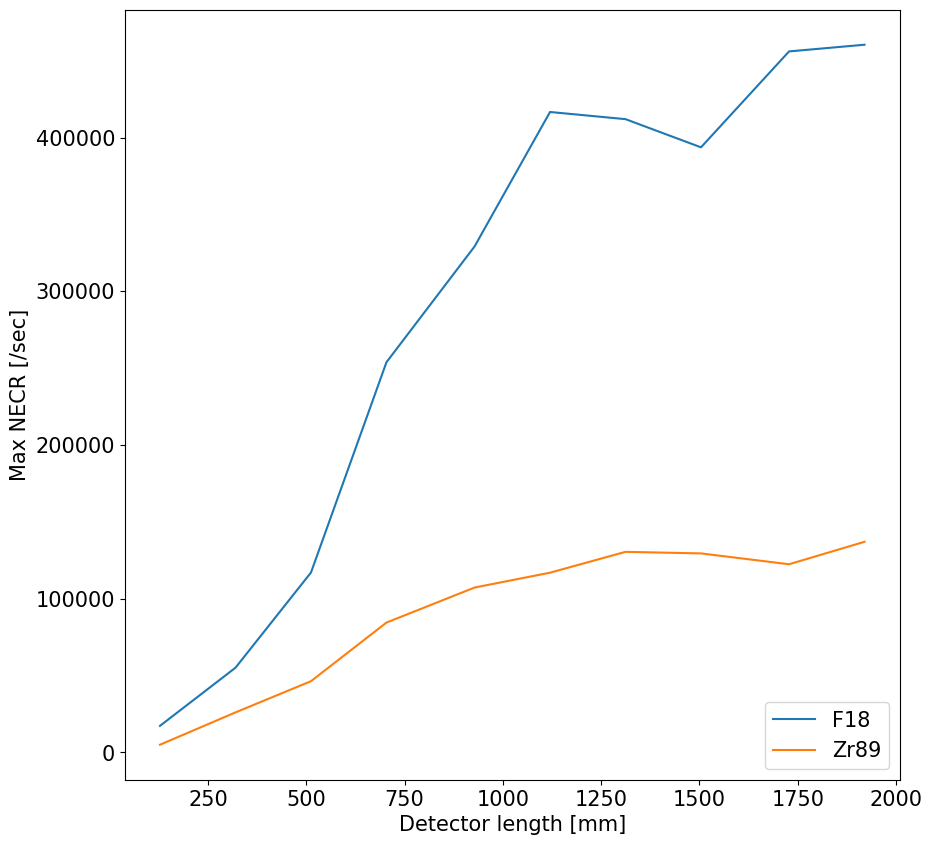

In [4]:
for i, isotope in enumerate( isotopes ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=isotope )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( isotopes )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()